# 1. Import needed libraries

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import zipfile
!unzip /content/dataset.zip

unzip:  cannot find or open /content/dataset.zip, /content/dataset.zip.zip or /content/dataset.zip.ZIP.


# 2. Preprocessing

## 2.1 Load data

In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('/content/Training')

In [ ]:
tr_df

,Class Path,Class
0,/content/Training/meningioma/Tr-me_0512.jpg,meningioma
1,/content/Training/meningioma/Tr-me_0889.jpg,meningioma
2,/content/Training/meningioma/Tr-me_1218.jpg,meningioma
3,/content/Training/meningioma/Tr-me_0758.jpg,meningioma
4,/content/Training/meningioma/Tr-me_0267.jpg,meningioma
...,...,...
5707,/content/Training/notumor/Tr-no_0116.jpg,notumor
5708,/content/Training/notumor/Tr-no_0993.jpg,notumor
5709,/content/Training/notumor/Tr-no_0788.jpg,notumor
5710,/content/Training/notumor/Tr-no_0601.jpg,notumor


In [ ]:
ts_df = test_df('/content/Testing')

In [ ]:
ts_df

,Class Path,Class
0,/content/Testing/meningioma/Te-me_0039.jpg,meningioma
1,/content/Testing/meningioma/Te-me_0177.jpg,meningioma
2,/content/Testing/meningioma/Te-me_0148.jpg,meningioma
3,/content/Testing/meningioma/Te-me_0063.jpg,meningioma
4,/content/Testing/meningioma/Te-me_0136.jpg,meningioma
...,...,...
1306,/content/Testing/notumor/Te-no_0295.jpg,notumor
1307,/content/Testing/notumor/Te-no_0308.jpg,notumor
1308,/content/Testing/notumor/Te-no_0404.jpg,notumor
1309,/content/Testing/notumor/Te-no_0323.jpg,notumor


## 2.2 Split data into train, test, valid

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=42, stratify=ts_df['Class'])

In [ ]:
valid_df

,Class Path,Class
1143,/content/Testing/notumor/Te-no_0073.jpg,notumor
29,/content/Testing/meningioma/Te-me_0228.jpg,meningioma
1076,/content/Testing/notumor/Te-no_0092.jpg,notumor
464,/content/Testing/glioma/Te-gl_0116.jpg,glioma
291,/content/Testing/meningioma/Te-me_0080.jpg,meningioma
...,...,...
177,/content/Testing/meningioma/Te-me_0292.jpg,meningioma
433,/content/Testing/glioma/Te-gl_0097.jpg,glioma
415,/content/Testing/glioma/Te-gl_0017.jpg,glioma
1064,/content/Testing/notumor/Te-no_0399.jpg,notumor


## 2.3 Data preprocessing

In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# 3. Building Deep Learning Model

In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

base_model.trainable = False

inputs = Input(shape = img_shape)

x = base_model(inputs)

x = Flatten()(x)

x = Dropout(rate= 0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= 0.25)(x)
x = Dense(4, activation= 'softmax')(x)

model = Model(inputs, x)

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


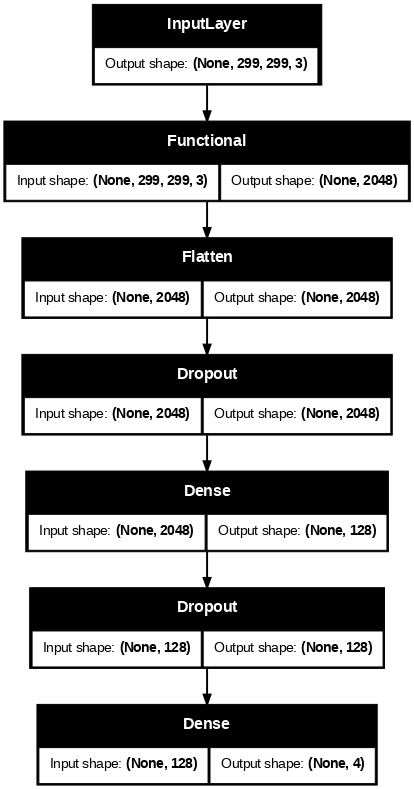

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70,)

# 4. Training

In [ ]:
hist = model.fit(tr_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 100s 414ms/step - accuracy: 0.6365 - loss: 1.0108 - precision: 0.6815 - recall: 0.5758 - val_accuracy: 0.7908 - val_loss: 0.5231 - val_precision: 0.8113 - val_recall: 0.7679
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 256ms/step - accuracy: 0.8164 - loss: 0.4652 - precision: 0.8476 - recall: 0.7853 - val_accuracy: 0.8458 - val_loss: 0.4225 - val_precision: 0.8660 - val_recall: 0.8092
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.8601 - loss: 0.3762 - precision: 0.8801 - recall: 0.8391 - val_accuracy: 0.8427 - val_loss: 0.3835 - val_precision: 0.8673 - val_recall: 0.8183
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.8798 - loss: 0.3422 - precision: 0.9002 - recall: 0.8618 - val_accuracy: 0.8626 - val_loss: 0.3502 - val_precision: 0.8982 - val_recall: 0.8351
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 48s 266ms/step - accuracy: 0.8833 - loss: 0.3239 - precision: 0.8937 - recall: 0.8690 - val_accuracy: 0.8412 - v

In [ ]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [ ]:
tr_gen.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

# Fine-Tuning

In [ ]:
len(base_model.layers)

133

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

history_fine = model.fit(tr_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 139s 608ms/step - accuracy: 0.8829 - loss: 0.3409 - precision_1: 0.8997 - recall_1: 0.8646 - val_accuracy: 0.9802 - val_loss: 0.0625 - val_precision_1: 0.9832 - val_recall_1: 0.9802
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 513ms/step - accuracy: 0.9812 - loss: 0.0518 - precision_1: 0.9835 - recall_1: 0.9802 - val_accuracy: 0.9908 - val_loss: 0.0251 - val_precision_1: 0.9908 - val_recall_1: 0.9908
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 511ms/step - accuracy: 0.9912 - loss: 0.0238 - precision_1: 0.9924 - recall_1: 0.9908 - val_accuracy: 0.9908 - val_loss: 0.0221 - val_precision_1: 0.9908 - val_recall_1: 0.9908
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 510ms/step - accuracy: 0.9976 - loss: 0.0068 - precision_1: 0.9976 - recall_1: 0.9976 - val_accuracy: 0.9985 - val_loss: 0.0076 - val_precision_1: 0.9985 - val_recall_1: 0.9985
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 513ms/step - accuracy: 0.9974 - loss: 0.0101 - precision_1: 0.9976 - recall_

In [ ]:
model.save("/content/sample_data/best_model.keras")

## 4.1 Visualize model performance

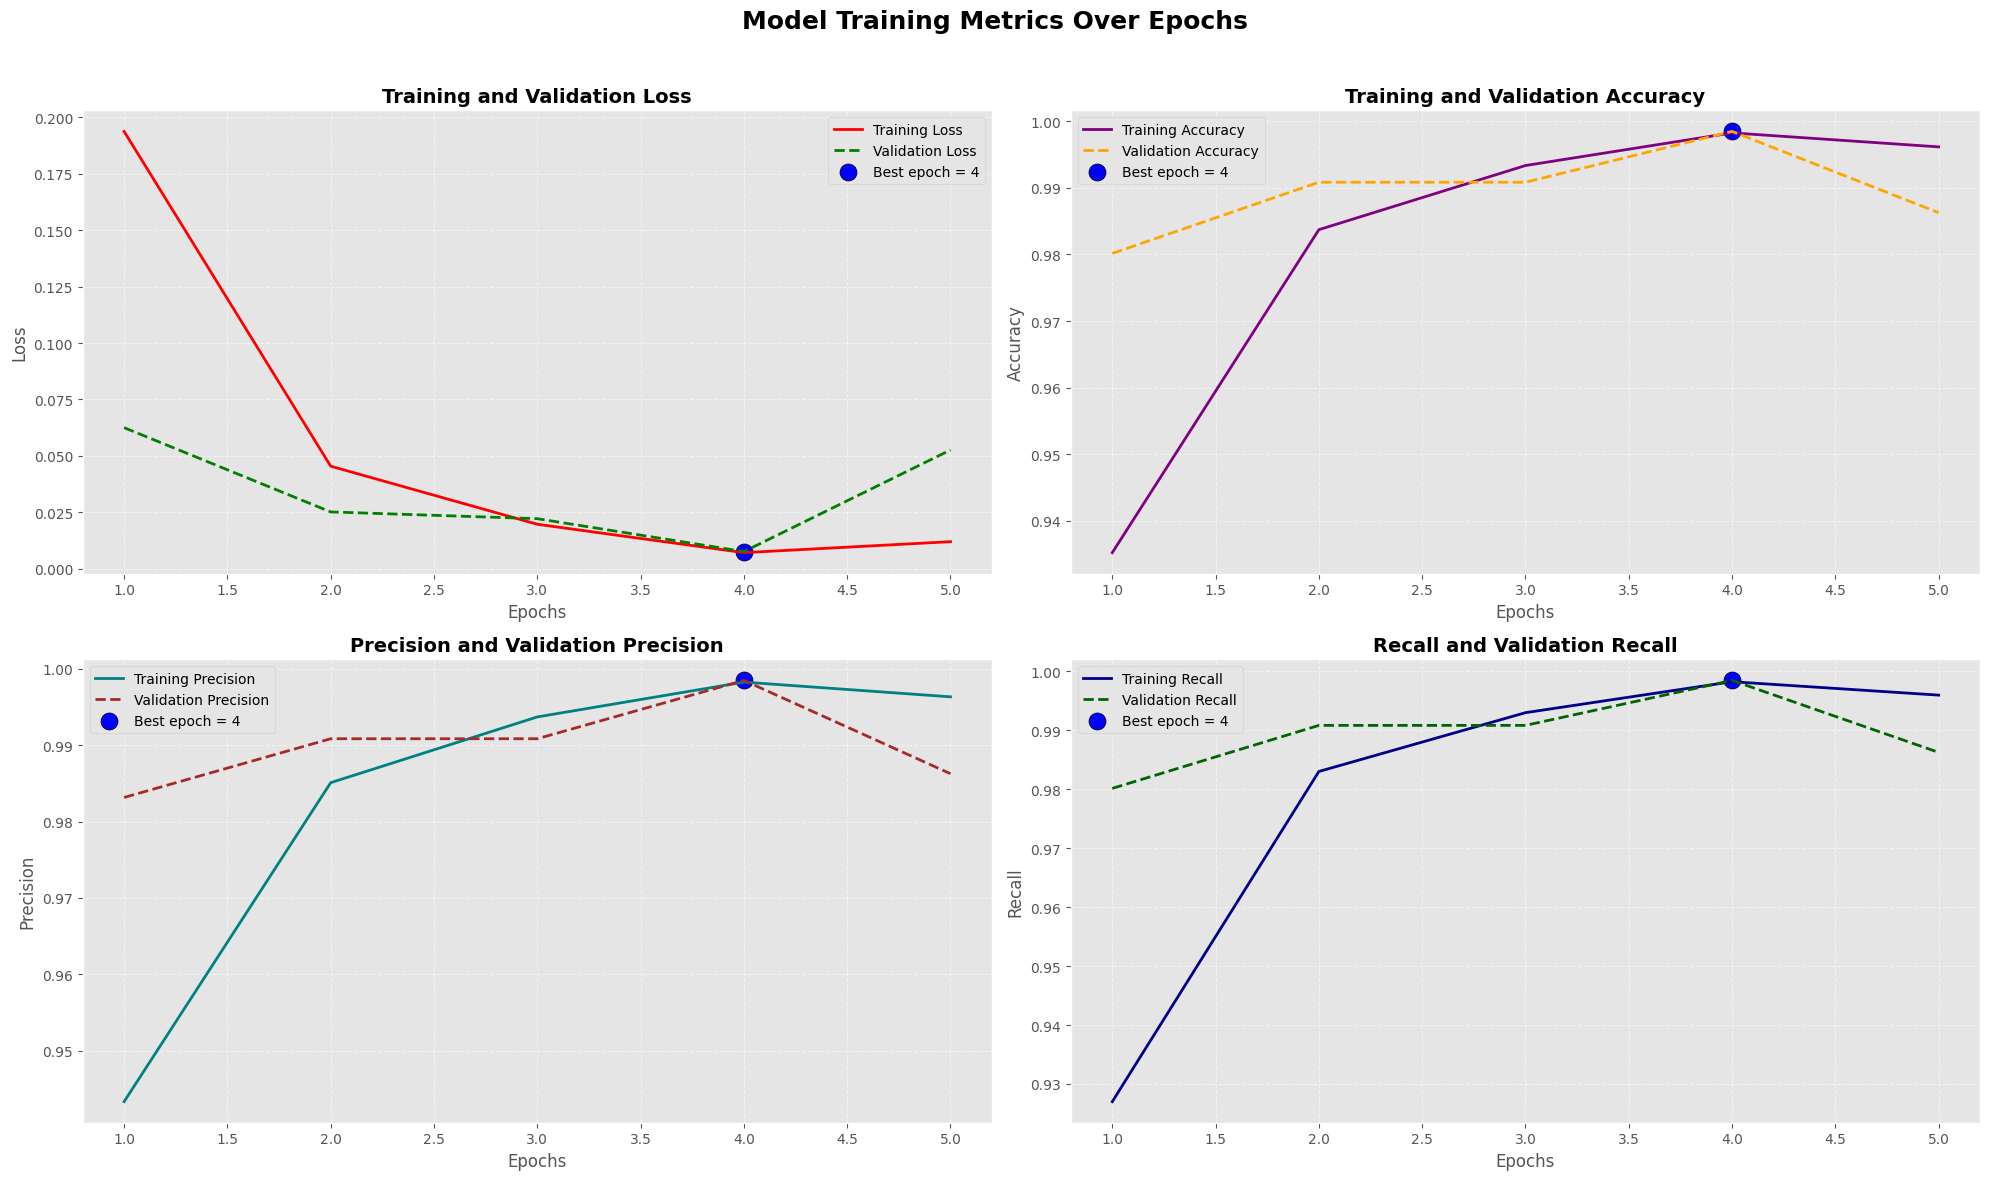

In [ ]:
tr_acc = history_fine.history['accuracy']
tr_loss = history_fine.history['loss']
tr_per = history_fine.history['precision_1']
tr_recall = history_fine.history['recall_1']
val_acc = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']
val_per = history_fine.history['val_precision_1']
val_recall = history_fine.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Define a modern style
plt.style.use('ggplot')
plt.figure(figsize=(20, 12))

# Plot Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, color='red', label='Training Loss', linewidth=2)
plt.plot(Epochs, val_loss, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label, edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Plot Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, color='purple', label='Training Accuracy', linewidth=2)
plt.plot(Epochs, val_acc, color='orange', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label, edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Plot Precision and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, color='teal', label='Training Precision', linewidth=2)
plt.plot(Epochs, val_per, color='brown', label='Validation Precision', linestyle='--', linewidth=2)
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label, edgecolors='black')
plt.title('Precision and Validation Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Plot Recall and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, color='darkblue', label='Training Recall', linewidth=2)
plt.plot(Epochs, val_recall, color='darkgreen', label='Validation Recall', linestyle='--', linewidth=2)
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label, edgecolors='black')
plt.title('Recall and Validation Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Add a title for the entire figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 5. Testing and Evaluation

## 5.1 Evaluate

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - accuracy: 0.9983 - loss: 0.0045 - precision_1: 0.9983 - recall_1: 0.9983
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9948 - loss: 0.0209 - precision_1: 0.9948 - recall_1: 0.9948
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9931 - loss: 0.0575 - precision_1: 0.9931 - recall_1: 0.9931
Train Loss: 0.0040
Train Accuracy: 99.86%
--------------------
Validation Loss: 0.0488
Validation Accuracy: 98.78%
--------------------
Test Loss: 0.0594
Test Accuracy: 99.24%


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step


In [ ]:
class_dict = tr_gen.class_indices

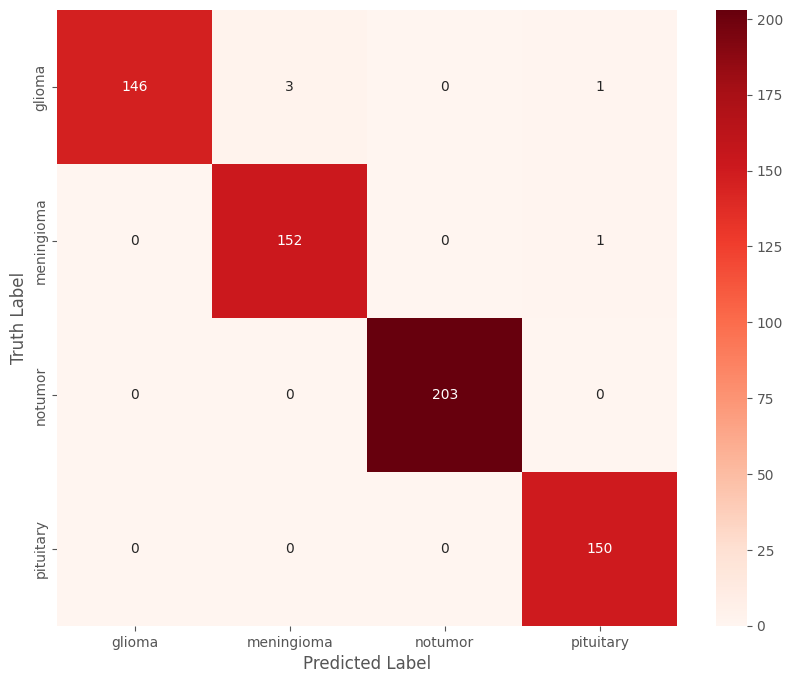

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       150
           1       0.98      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 576ms/step - accuracy: 0.9984 - loss: 0.0042 - precision_1: 0.9984 - recall_1: 0.9984
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 558ms/step - accuracy: 0.9877 - loss: 0.0493 - precision_1: 0.9877 - recall_1: 0.9877
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.9931 - loss: 0.0575 - precision_1: 0.9931 - recall_1: 0.9931
Train Loss: 0.0038
Train Accuracy: 99.88%
--------------------
Validation Loss: 0.0511
Validation Accuracy: 98.78%
--------------------
Test Loss: 0.0594
Test Accuracy: 99.24%
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step


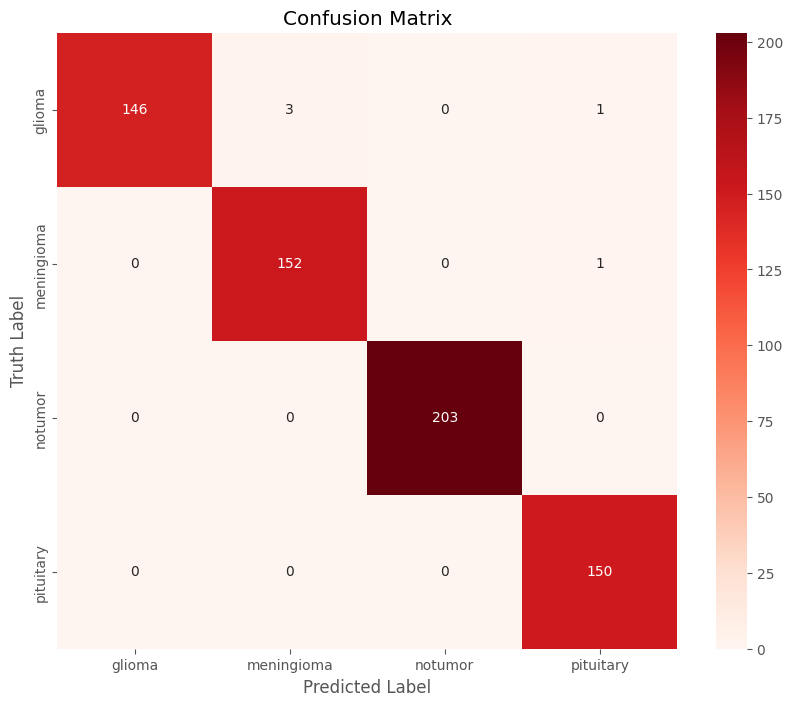

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       150
  meningioma       0.98      0.99      0.99       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      1.00      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656

ROC-AUC analysis is only applicable for binary classification.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on train, validation, and test sets
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

# Print evaluation scores
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

# Predictions and true labels for the test set
y_pred_proba = model.predict(ts_gen, verbose=1)
y_pred = y_pred_proba.argmax(axis=1)
y_true = ts_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(class_dict.keys())  # Replace `class_dict` with your actual class label dictionary
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
clr = classification_report(y_true, y_pred, target_names=labels)
print("Classification Report:")
print(clr)

# ROC-AUC metrics
if len(labels) == 2:  # Binary classification
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.5)
    plt.show()

    print(f"ROC-AUC Score: {roc_auc:.4f}")
else:
    print("ROC-AUC analysis is only applicable for binary classification.")

## 5.2 Testing

In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


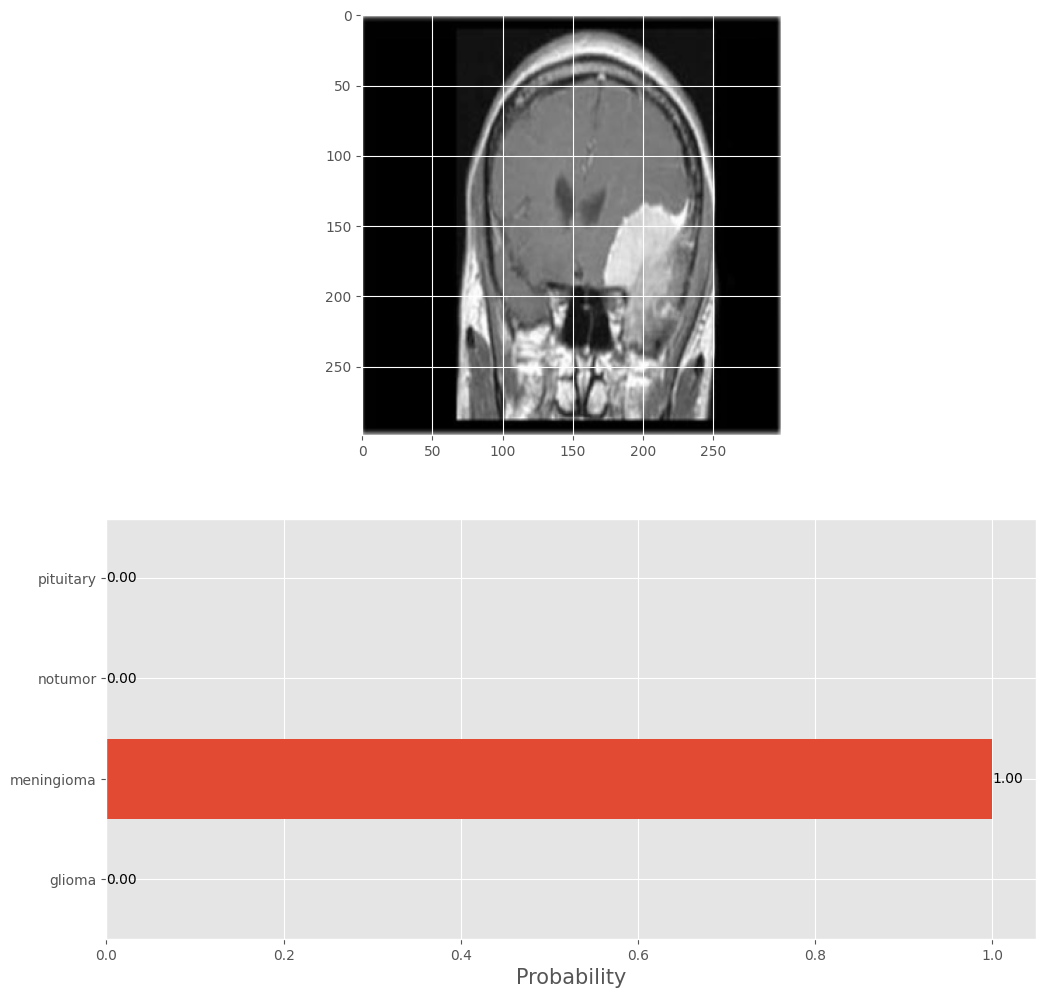

In [ ]:
predict('/content/Testing/meningioma/Te-meTr_0000.jpg')

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7be392e4bb38c3c49a4dad2769b13b2873a54ee2be2fa57ec75360443d942dd9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


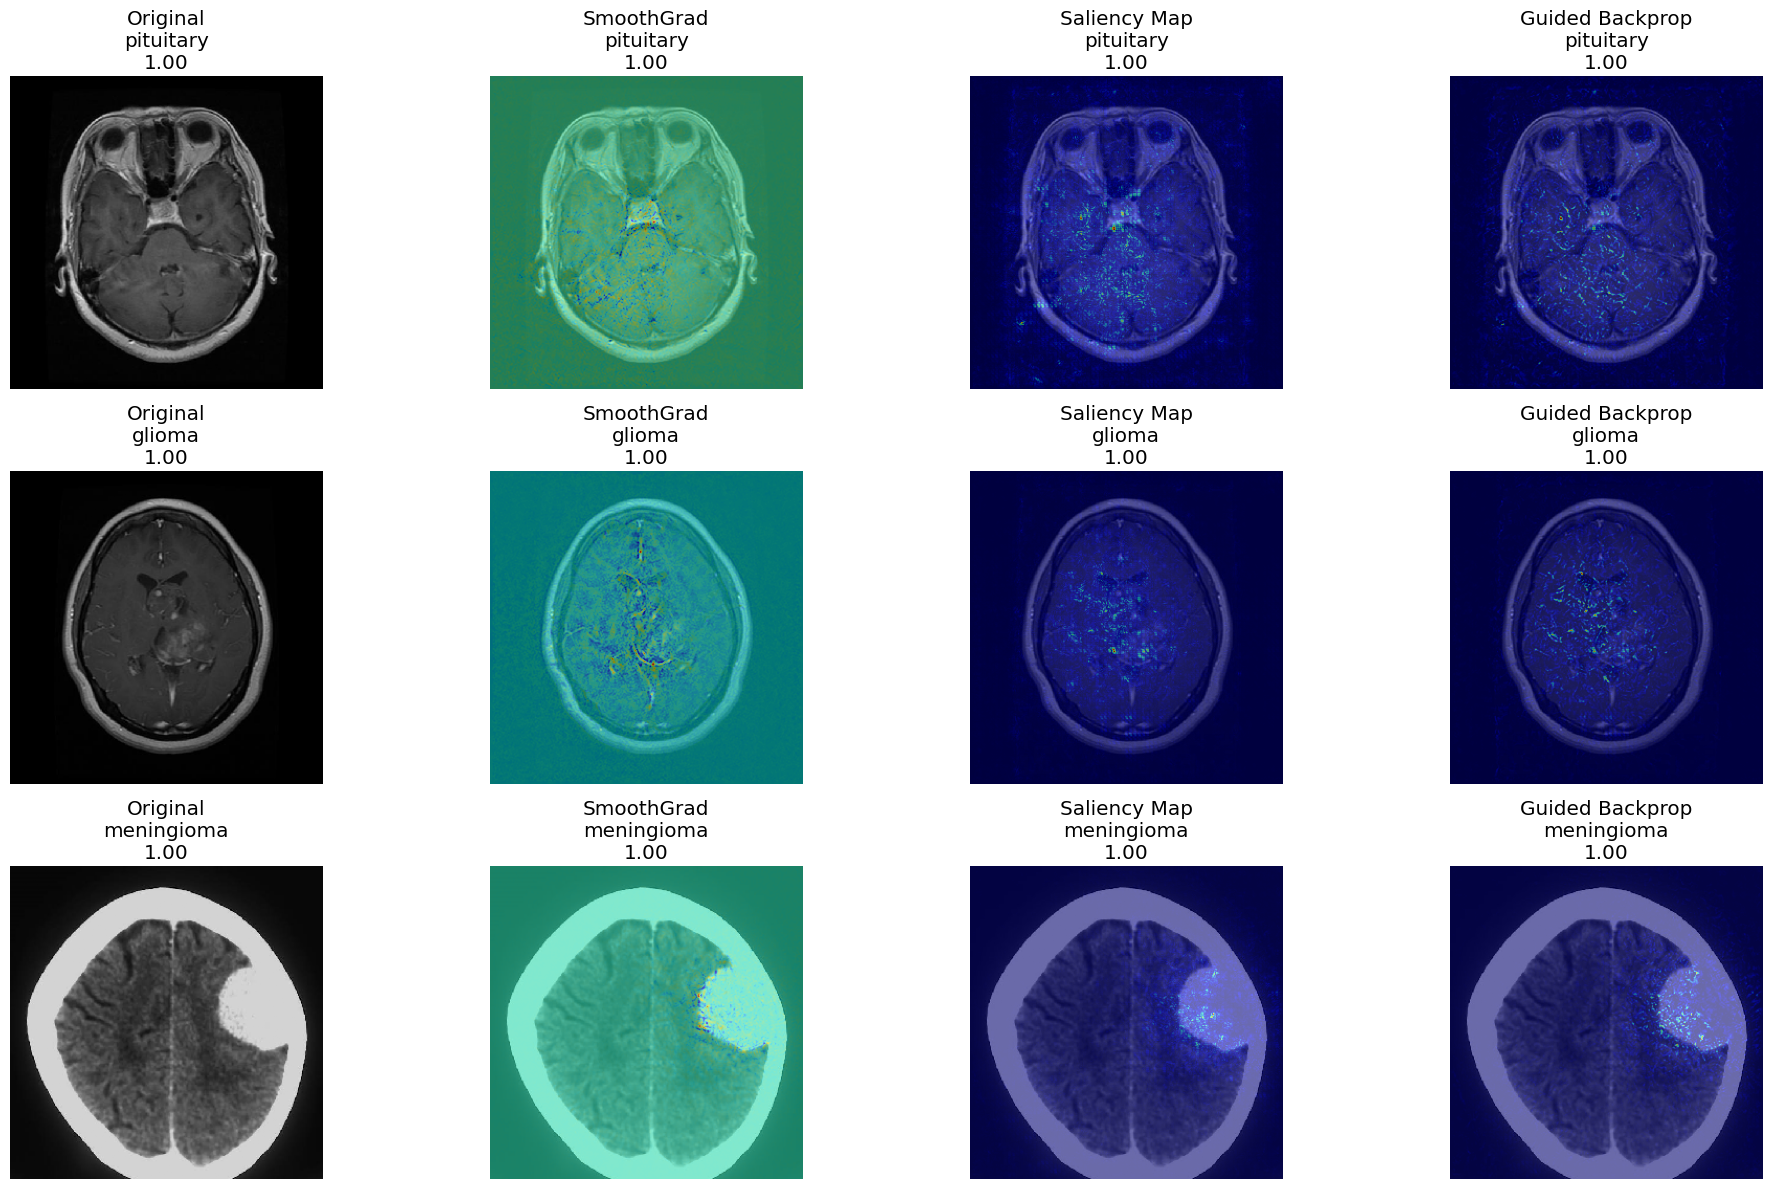

,Image,Prediction,Confidence,SmoothGrad_Focus,SmoothGrad_Sparsity,Saliency_Focus,Saliency_Sparsity,Guided BP_Focus,Guided BP_Sparsity
0,Image 1,pituitary,1.000000,0.429341,0.460163,0.001678,0.003835,0.000847,0.002262
1,Image 2,glioma,1.000000,0.360907,0.380464,0.000010,0.000027,0.000005,0.000013
2,Image 3,meningioma,0.999995,0.406312,0.414347,0.017878,0.043816,0.013692,0.032892



Stability Metrics:
{'SmoothGrad_Stability': 0.40244115413731346, 'Saliency_Stability': 0.6455662616579184, 'Guided BP_Stability': 0.6076113911968404}


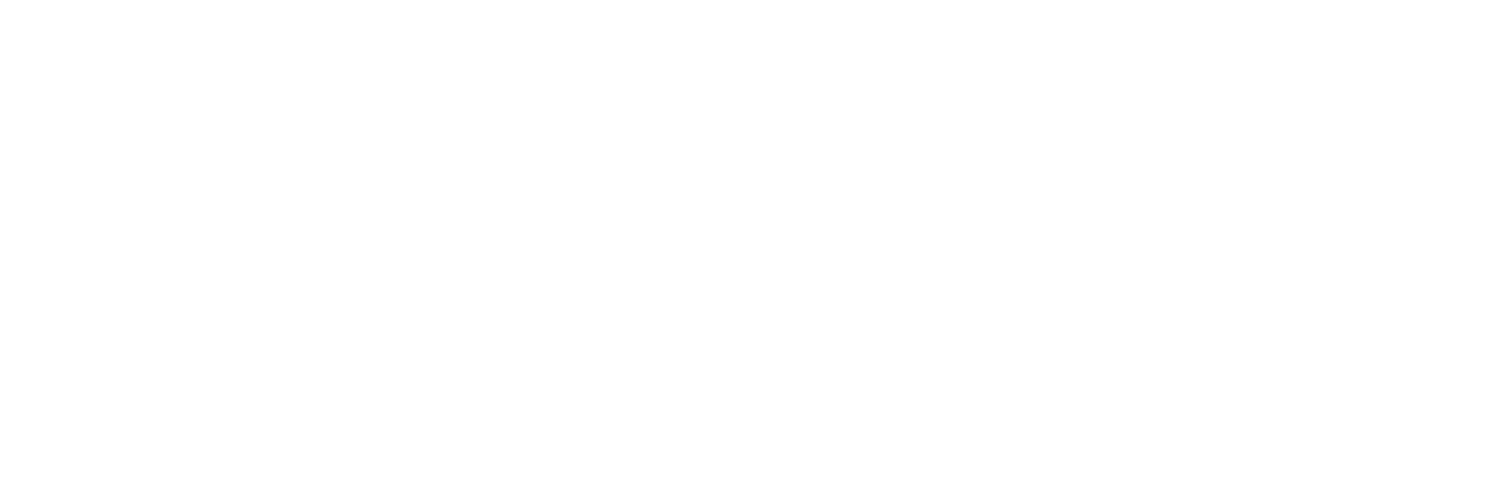

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, mutual_info_score
from scipy.stats import entropy
import seaborn as sns
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
import cv2
from itertools import product
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_image(image_path, target_size=(299, 299)):
    """Load and preprocess a single image."""
    img = load_img(image_path, target_size=target_size, color_mode='rgb')
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return img_array

class SmoothGrad:
    def __init__(self, model, num_samples=50, noise_level=0.1):
        self.model = model
        self.num_samples = num_samples
        self.noise_level = noise_level

    def compute_gradients(self, input_image, target_class):
        """Compute smoothed gradients."""
        gradients = []

        for _ in range(self.num_samples):
            noise = np.random.normal(0, self.noise_level, input_image.shape)
            noisy_image = input_image + noise

            with tf.GradientTape() as tape:
                inputs = tf.convert_to_tensor(noisy_image[np.newaxis, ...])
                tape.watch(inputs)
                predictions = self.model(inputs)
                class_output = predictions[:, target_class]

            grads = tape.gradient(class_output, inputs)
            gradients.append(grads[0].numpy())

        return np.mean(gradients, axis=0)

def saliency_map(model, input_image, target_class):
    """Compute vanilla saliency map."""
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(input_image[np.newaxis, ...])
        tape.watch(inputs)
        predictions = model(inputs)
        class_output = predictions[:, target_class]

    grads = tape.gradient(class_output, inputs)[0]
    return np.abs(grads)

def guided_backprop(model, input_image, target_class):
    """Compute guided backpropagation."""
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(input_image[np.newaxis, ...])
        tape.watch(inputs)
        predictions = model(inputs)
        class_output = predictions[:, target_class]

    grads = tape.gradient(class_output, inputs)[0]
    return np.maximum(grads, 0)



def visualize_explanation(image, explanation, ax, title):
    """Visualize the explanation overlay on the image."""
    if len(explanation.shape) == 3:
        explanation = np.mean(explanation, axis=-1)

    normalized_exp = (explanation - explanation.min()) / (explanation.max() - explanation.min() + 1e-8)

    ax.imshow(image)
    overlay = ax.imshow(normalized_exp, cmap='jet', alpha=0.5)
    ax.set_title(title)
    ax.axis('off')
    return overlay

def compare_multiple_images(model, image_file_paths, category_labels):
    """Compare XAI techniques across multiple images."""
    num_images = len(image_file_paths)
    fig, axes = plt.subplots(num_images, 4, figsize=(20, 4 * num_images))

    if num_images == 1:
        axes = axes[np.newaxis, :]

    methods = {
        'Original': lambda img, idx: (img, 'Original'),
        'SmoothGrad': lambda img, idx: (SmoothGrad(model).compute_gradients(img, idx), 'SmoothGrad'),
        'Saliency': lambda img, idx: (saliency_map(model, img, idx), 'Saliency Map'),
        'Guided BP': lambda img, idx: (guided_backprop(model, img, idx), 'Guided Backprop'),
        #'Integrated': lambda img, idx: (integrated_gradients(img, model), 'Integrated Gradients')
    }

    metrics_data = []

    for i, image_path in enumerate(image_file_paths):
        input_image = load_and_preprocess_image(image_path)
        predictions = model.predict(np.array([input_image]), verbose=0)
        predicted_class = np.argmax(predictions[0])
        predicted_label = category_labels[predicted_class]
        confidence = predictions[0][predicted_class]

        image_metrics = {'Image': f'Image {i+1}', 'Prediction': predicted_label, 'Confidence': confidence}

        for j, (method_name, method_func) in enumerate(methods.items()):
            try:
                result, title = method_func(input_image, predicted_class)

                if method_name == 'Original':
                    axes[i, j].imshow(input_image)
                else:
                    if len(result.shape) == 3:
                        result = np.mean(result, axis=-1)
                    normalized_result = (result - result.min()) / (result.max() - result.min() + 1e-8)
                    axes[i, j].imshow(input_image)
                    axes[i, j].imshow(normalized_result, cmap='jet', alpha=0.5)

                if method_name != 'Original':
                    image_metrics[f'{method_name}_Focus'] = np.mean(normalized_result)
                    image_metrics[f'{method_name}_Sparsity'] = np.percentile(normalized_result.flatten(), 90)

            except Exception as e:
                print(f"{method_name} failed for image {i+1}: {str(e)}")
                axes[i, j].text(0.5, 0.5, f'{method_name}\nFailed', ha='center', va='center')

            axes[i, j].set_title(f'{title}\n{predicted_label}\n{confidence:.2f}')
            axes[i, j].axis('off')

        metrics_data.append(image_metrics)

    plt.tight_layout()
    plt.show()

    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

    return metrics_df

def calculate_explanation_stability(model, image_file_path, category_labels, num_samples=10):
    """Calculate stability metrics for different XAI methods."""
    input_image = load_and_preprocess_image(image_file_path)
    predictions = model.predict(np.array([input_image]), verbose=0)
    predicted_class = np.argmax(predictions[0])

    stability_metrics = {}

    perturbed_images = []
    for _ in range(num_samples):
        noise = np.random.normal(0, 0.01, input_image.shape)
        perturbed_images.append(input_image + noise)

    methods = {
        'SmoothGrad': lambda img: SmoothGrad(model).compute_gradients(img, predicted_class),
        'Saliency': lambda img: saliency_map(model, img, predicted_class),
        'Guided BP': lambda img: guided_backprop(model, img, predicted_class)
    }

    for method_name, method_func in methods.items():
        try:
            explanations = []
            for perturbed_img in perturbed_images:
                explanation = method_func(perturbed_img)
                if len(explanation.shape) == 3:
                    explanation = np.mean(explanation, axis=-1)
                explanations.append(explanation.flatten())

            explanation_correlation = np.corrcoef(explanations)[0, 1:]
            stability_metrics[f'{method_name}_Stability'] = np.mean(explanation_correlation)

        except Exception as e:
            print(f"{method_name} stability calculation failed: {str(e)}")
            stability_metrics[f'{method_name}_Stability'] = None

    return stability_metrics

# Main execution
try:
    # Load model and set up paths
    model = load_model('/content/sample_data/best_model.keras')
    category_labels = ["glioma", "meningioma", "notumor", "pituitary"]

    image_file_paths = [
        "/content/Testing/pituitary/Te-pi_0019.jpg",
        "/content/Testing/glioma/Te-gl_0049.jpg",
        "/content/Testing/meningioma/Te-meTr_0009.jpg"
    ]

    # Get model's input shape
    input_shape = model.input_shape[1:3]

    # Run analysis
    metrics_df = compare_multiple_images(model, image_file_paths, category_labels)
    stability_metrics = calculate_explanation_stability(model, image_file_paths[0], category_labels)

    print("\nStability Metrics:")
    print(stability_metrics)

    # Additional visualization of stability metrics


except Exception as e:
    print(f"An error occurred: {str(e)}")

# Gradio interface for classifying brain tumors

In [ ]:
import gradio as gr
import numpy as np

# Load the model

model.load_weights("/content/sample_data/best_model.keras")


class_names = [
    'glioma',
    'meningioma',
    'notumor',
    'pituitary',
]

def classify_tumor(input_image):

    img = Image.fromarray(input_image)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    prediction = model.predict(img)

    confidences = {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}

    return {class_name: conf for class_name, conf in sorted(confidences.items(), key=lambda x: x[1], reverse=True)}

iface = gr.Interface(
    fn=classify_tumor,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=5),
    title="Brain Tumor Classification",
    description="Upload an image of a Brain to classify its tumor.",
    theme=gr.themes.Soft()
)

# Launch the interface
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d35f8f34ca6e6d6d17.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
